In [26]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import datetime
import statsmodels.api as sm
import scipy
import warnings
from scipy import stats
warnings.filterwarnings("ignore")
from statsmodels import api as stm 
from statsmodels import tools
from scipy.optimize import minimize
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import prettytable as pt
from numpy import random
import gc 
import psutil
import os
plt.style.use("seaborn")
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
%config InlineBackend.figure_format='retina'
%matplotlib inline

class back_test():
    # 输入的信号应该是时间点，当天仓位的大小
    # 价格应该是所有时间点的价格数据
    #输入数据格式都是dataframe格式
    def __init__(self,position, price,frequency):
        
        self.asset_price = price
        self.asset_price.columns = [0]
        self.position = pd.DataFrame(position.values,index = position.index) 
        self.asset_return = price.pct_change()
        self.asset_return.iloc[0] = 0
        self.frequency = frequency
        
    def calculate_net_value(self):
        self.each_return = pd.DataFrame(self.position.values*self.asset_return.values, index = self.position.index)
        self.net_value = (self.each_return+1).cumprod()
    
    def drawdown(self):
        self.withdraw = (self.net_value-self.net_value.cummax())/self.net_value.cummax()
        self.max_withdraw = (self.withdraw).min().values[0]
        
    def win_and_odd(self):
        
        #用operation来记录是否清仓，如果清仓则计入一次操作，可以用来计算胜率等指标，如果是则计1
        self.operation = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #long_short用来判断清仓前的这次操作是多/空操作，多的话计1，空计-1
        self.long_short = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        #当仓位变成0的时候需要记下清仓,同时需要判断本次是否是否相比上个时间点是否调仓了
        #虽然这里的仓位0表示的是上一个交易时点结束时或者本次交易时间点开始时清仓，所以需要向上错一位
        self.operation[((self.position == 0).values)*((self.position.diff().abs()>0).values)] = 1 
        copy = pd.DataFrame(np.append(self.operation.iloc[1:].values, self.position.iloc[-1].abs()>0),index = self.operation.index)
        self.operation = copy
        
        #如果多翻空或者空翻多,认为中间发生了清仓，记一次操作,这里的记时指的是该交易时间点结束时清仓
        change_position = np.append((self.position.values[:-1]*self.position.values[1:]<0),[self.position.iloc[-1].abs()>0])
        self.operation[change_position] = 1 
        
        #用来记录每次操作是盈利/亏损
        self.each_operation_return = pd.DataFrame(np.zeros([len(self.position),1]),index = self.position.index)
        self.each_operation_return[(self.operation>0).values] = self.net_value[(self.operation>0).values].pct_change()#每次操作的收益
        self.each_operation_return.loc[self.each_operation_return[(self.operation>0).values].index[0]] = self.net_value[(self.operation>0).values].values[0,0]-1
        #如果是多空切换
        self.long_short[(self.operation>0).values] = (self.position[(self.operation>0).values] > 0 )*1+( self.position[(self.operation>0).values] < 0 )*(-1)#如果是多翻空的情况
#         #如果是清仓的情况
#         long_short[(self.position == 0).values*(self.position.diff()>0).values] = -1
#         long_short[(self.position == 0).values*(self.position.diff()<0).values] = 1  
        
        #计算总的胜率和赔率
        self.all_number = len(self.operation[(self.operation.abs()>0).values])
        self.win_number = len(self.each_operation_return[(self.each_operation_return>0).values])
        self.win_rate = self.win_number/self.all_number
        
        self.win_part = self.each_operation_return[ (self.each_operation_return>0).values ].mean().values[0]
        self.lost_part = -self.each_operation_return[(self.each_operation_return<0).values].mean().values[0]
        self.odds_rate = self.win_part/self.lost_part
        
        #计算做多胜率和赔率
        self.long_operation_return = self.each_operation_return[(self.long_short>0).values]
        self.long_all_number = len(self.long_operation_return)
        self.long_win_number = len(self.long_operation_return[(self.long_operation_return>0).values])
        try:
            self.long_win_rate = self.long_win_number/self.long_all_number
        except:
            self.long_win_rate = 0
        self.long_win_part = self.long_operation_return[(self.long_operation_return>0).values].mean().values[0]
        self.long_lost_part = -self.long_operation_return[(self.long_operation_return<0).values].mean().values[0]
        try:
            self.long_odds_rate = self.long_win_part/self.long_lost_part
        except:
            self.long_odds_rate =0
        
        #计算做空胜率和赔率
        self.short_operation_return = self.each_operation_return[(self.long_short<0).values]
        self.short_all_number = len(self.short_operation_return)
        self.short_win_number = len(self.short_operation_return[(self.short_operation_return>0).values])
        try:
            self.short_win_rate = self.short_win_number/self.short_all_number
        except:
            self.short_win_rate=0
            
        self.short_win_part = self.short_operation_return[(self.short_operation_return>0).values].mean().values[0]
        self.short_lost_part = -self.short_operation_return[(self.short_operation_return<0).values].mean().values[0]
        try:
            self.short_odds_rate = self.short_win_part/self.short_lost_part
        except:
            self.short_odds_rate=0

        
    #计算年化回报、年化波动率和夏普比
    def sharpe_ratio(self,frequency):
        self.annual_return = self.net_value.values[-1,0]**(frequency/len(self.net_value))-1
        self.annual_std = self.each_return.values.std()*np.sqrt(frequency)
        self.sharpe = self.annual_return/self.annual_std
    
    def show_result(self):
        self.calculate_net_value()
        self.sharpe_ratio(250*self.frequency)
        self.drawdown()
        self.win_and_odd()
        tb = pt.PrettyTable()
        tb.field_names = ["   ","回测结果展示"]
        tb.add_row(["年化收益率",round(self.annual_return,4)])
        tb.add_row(["年化波动率",round(self.annual_std,4)])
        tb.add_row(["夏普比",round(self.sharpe,4)])
        tb.add_row(["开仓次数",self.all_number])
        tb.add_row(["胜率",round(self.win_rate,4)])
        tb.add_row(["赔率",round(self.odds_rate,4)])
        
        tb.add_row(["做多次数",self.long_all_number])
        tb.add_row(["做多胜率",round(self.long_win_rate,4)])
        tb.add_row(["做多赔率",round(self.long_odds_rate,4)])
        
        tb.add_row(["做空次数",self.short_all_number])
        tb.add_row(["做空胜率",round(self.short_win_rate,4)])
        tb.add_row(["做空赔率",round(self.short_odds_rate,4)])
        tb.add_row(["最大回撤",self.max_withdraw.round(4)])
        
        tb.add_row(["回测开始时间",str(self.position.index[0])])
        tb.add_row(["回测结束时间",str(self.position.index[-1])])
        
        print(tb)
        
    def result_plot(self):
        cc= self.net_value.copy()
        res = pd.concat([cc,self.asset_price/self.asset_price.iloc[0]],axis=1).dropna()
        res.columns = ["净值",'裸多净值']
        res.iloc[:,:2].plot(legend=True,figsize=(15,10),title='曲线')
        self.out = res

# T

### 数据预处理

In [66]:
###给出高/开/低/收
day_number = 18*3
year = [15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*7
file_name = ['T'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]

def draw_data(raw_data):
    data = raw_data[['open','close','high','low','volume']]#我们只使用高开低收和成交量5个数据
    data.iloc[:,4] = data.iloc[:,4].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data['open'] = [0]*14+list(data.iloc[:-14,0].values)#开盘价
    data['high'] = data['high'].rolling(15).max()#最大值
    data['low'] = data['low'].rolling(15).min()#最小值
    
    data=data[data.index.minute.isin([15,30,45,0])] 
    data['open'] = data['open']/data['close']
    data['high'] = data['high']/data['close']
    data['low'] = data['low']/data['close']
    data['close'] = data['close'].pct_change()
    
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,4].rolling(day_number).sum()<nn.iloc[:,9].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()

future1.iloc[0,1] = 0
future_integrate = future1.loc[future1.index[1]:future1[(future1.iloc[:,4]>0).values].index[-1]]
T_future_price = future_integrate.copy()
T_future_price.iloc[:,1] = (T_future_price.iloc[:,1]+1).cumprod()
T_future_price['open'] = T_future_price['open']*T_future_price['close']
T_future_price['high'] = T_future_price['high']*T_future_price['close']
T_future_price['low'] = T_future_price['low']*T_future_price['close']
T_future_price.iloc[:,0:4] = T_future_price.iloc[:,0:4]*100

处理文件T1503.CCFX.xlsx
处理文件T1506.CCFX.xlsx
处理文件T1509.CCFX.xlsx
处理文件T1512.CCFX.xlsx
合约切换时间： 2015-08-14 11:30:00
处理文件T1603.CCFX.xlsx
合约切换时间： 2015-11-24 10:45:00
处理文件T1606.CCFX.xlsx
合约切换时间： 2016-02-18 11:15:00
处理文件T1609.CCFX.xlsx
合约切换时间： 2016-05-10 10:15:00
处理文件T1612.CCFX.xlsx
合约切换时间： 2016-08-11 14:00:00
处理文件T1703.CCFX.xlsx
合约切换时间： 2016-11-10 14:30:00
处理文件T1706.CCFX.xlsx
合约切换时间： 2017-01-25 10:15:00
处理文件T1709.CCFX.xlsx
合约切换时间： 2017-05-11 13:45:00
处理文件T1712.CCFX.xlsx
合约切换时间： 2017-08-10 10:15:00
处理文件T1803.CCFX.xlsx
合约切换时间： 2017-11-13 10:30:00
处理文件T1806.CCFX.xlsx
合约切换时间： 2018-02-12 11:00:00
处理文件T1809.CCFX.xlsx
合约切换时间： 2018-05-21 10:45:00
处理文件T1812.CCFX.xlsx
合约切换时间： 2018-08-16 13:30:00
处理文件T1903.CCFX.xlsx
合约切换时间： 2018-11-19 13:30:00
处理文件T1906.CCFX.xlsx
合约切换时间： 2019-02-21 14:15:00
处理文件T1909.CCFX.xlsx
合约切换时间： 2019-05-22 10:00:00
处理文件T1912.CCFX.xlsx
合约切换时间： 2019-08-15 13:30:00
处理文件T2003.CCFX.xlsx
合约切换时间： 2019-11-20 11:30:00
处理文件T2006.CCFX.xlsx
合约切换时间： 2020-02-19 10:15:00
处理文件T2009.CCFX.xlsx
合约切换时间： 

### 缺口统计

In [124]:
gap = pd.DataFrame((T_future_price.iloc[1:,3].values-T_future_price.iloc[:-1,2].values),index = T_future_price.index[1:])
box = []
for i in range(1,100):
    box.append(np.percentile(gap,i))

In [125]:
box

[-0.3217649119327173,
 -0.2627782357790497,
 -0.22868173076038545,
 -0.21068868238376126,
 -0.19538621242398335,
 -0.18082044377817624,
 -0.172872765032821,
 -0.1634538500989362,
 -0.15713455160408785,
 -0.15041953666782604,
 -0.14456257963080077,
 -0.139399630358227,
 -0.13468675851780176,
 -0.13051567112123053,
 -0.1260282771564647,
 -0.12346286197464451,
 -0.1195142753200713,
 -0.11581993628236889,
 -0.11344775205279234,
 -0.11021390651258683,
 -0.10820280296783835,
 -0.10493097806881535,
 -0.10321687414005964,
 -0.10027969111187929,
 -0.09792828577408841,
 -0.09724093033095471,
 -0.09388497618026292,
 -0.09255136377979056,
 -0.0903208060273073,
 -0.08777013763298669,
 -0.08702462927563204,
 -0.08436623276497983,
 -0.08260718836046976,
 -0.08161205872170285,
 -0.07977269677685683,
 -0.077952770181696,
 -0.07671286435612742,
 -0.07613414148739509,
 -0.07347605730835483,
 -0.07213520197856838,
 -0.07083000170956666,
 -0.07069598852400816,
 -0.06788747899209113,
 -0.06685312740792426,


In [ ]:
if a>0:
    print(2)
else if a<-1:
    print(3)

In [118]:
future_price['low'][1:1+8]

2015-03-20 10:00:00    99.577494
2015-03-20 10:15:00    99.634171
2015-03-20 10:30:00    99.665087
2015-03-20 10:45:00    99.649629
2015-03-20 11:00:00    99.654782
2015-03-20 11:15:00    99.675392
2015-03-20 11:30:00    99.706307
2015-03-20 13:15:00    99.082852
Name: low, dtype: float64

In [228]:
T_future_price

,open,close,high,low,volume,direction
2015-03-20 09:45:00,99.994847,99.639324,100.020610,99.469291,1016.0,-0.355523
2015-03-20 10:00:00,99.644477,99.649629,99.742374,99.577494,276.0,0.005153
2015-03-20 10:15:00,99.644477,99.665087,99.665087,99.634171,57.0,0.020610
2015-03-20 10:30:00,99.665087,99.701154,99.752679,99.665087,121.0,0.036068
2015-03-20 10:45:00,99.706307,99.680544,99.706307,99.649629,87.0,-0.025763
...,...,...,...,...,...,...
2020-12-25 14:15:00,110.537788,110.537788,110.543445,110.503844,2301.0,0.000000
2020-12-25 14:30:00,110.537788,110.594361,110.600018,110.532130,3686.0,0.056573
2020-12-25 14:45:00,110.594361,110.673563,110.679220,110.577389,4700.0,0.079202
2020-12-25 15:00:00,110.673563,110.690534,110.713164,110.656591,4613.0,0.016972


In [294]:
future_price = T_future_price

#定义趋势项，当均线连续上涨则证明有趋势
price_ave1=future_price['close'].rolling(int(50)).mean()
up_trend = (price_ave1.pct_change()>0).rolling(50).sum()>48
down_trend = (price_ave1.pct_change()<0).rolling(50).sum()>48
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["trend"]
future_price['trend']=trend
future_price = future_price.dropna()

long_return = []
short_return = []
time = []
c=datetime.date(2021, 7, 6)
long =0
short = 0

for i in range(1,len(future_price)-36):
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        #判断是什么时候出现的缺口
        
        morning=8
        afternoon=16
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==30):
            morning = 8
            afternoon =9+8
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==40):
            morning = 7
            afternoon=9+7
            
        if (future_price['low'][i:i+morning].min()>=future_price['high'][i-1]):
            if (future_price['open'].pct_change(3)[i+morning]>0)*(future_price['volume'][i]>1.5*future_price['volume'].rolling(30).mean().iloc[i]):#上午最后15min开盘买入，下午收盘卖出
            #if future_price['volume'][i]>3*future_price['volume'].rolling(30).mean().iloc[i]:
                long = (future_price['trend'][i+morning]>=0)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+long*morning+1]+future_price['close'][i+afternoon+1+long*morning])/2
                long_return.append(sell_price/buy_price-1)
                time.append(future_price.index[i])
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        morning=8
        afternoon=16
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==30):
            morning = 8
            afternoon =9+8
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==40):
            morning = 7
            afternoon=9+7    
    
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
    
            if (future_price['open'].pct_change(3)[i+morning]<0)*(future_price['volume'][i]>1.5*future_price['volume'].rolling(30).mean().iloc[i]):
                long = (future_price['trend'][i+morning]<=0)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+short*morning+1]+future_price['close'][i+afternoon+short*morning+1])/2
                short_return.append(1-sell_price/buy_price)
                time.append(future_price.index[i])

long_return = np.array(long_return)
long_win = sum(np.array(long_return)>0)/len(long_return)
long_odd = -long_return[(np.array(long_return)>0)].mean()/long_return[(np.array(long_return)<0)].mean()
print("做多个数:",len(long_return))
print("做多胜率:",long_win)
print("做多赔率:",long_odd)
print("做多预期收益倍数;",(1+long_odd)*long_win-1)


short_return = np.array(short_return)
short_win = sum(np.array(short_return)>0)/len(short_return)
short_odd = -short_return[(np.array(short_return)>0)].mean()/short_return[(np.array(short_return)<0)].mean()
print("做空个数:",len(short_return))
print("做空胜率:",short_win)
print("做空赔率:",short_odd)
print("做空预期收益倍数;",(1+short_odd)*short_win-1)

做多个数: 88
做多胜率: 0.5340909090909091
做多赔率: 1.1667113214150884
做多预期收益倍数; 0.1572208193921496
做空个数: 70
做空胜率: 0.6285714285714286
做空赔率: 1.9946024497076975
做空预期收益倍数; 0.8823215398162669


In [24]:
stop_win = 0.01 #止盈
cut_loss = -0.003 #止损
long_return = []
short_return = []
cut=datetime.date(2020, 7, 6)
position_data = pd.DataFrame(np.zeros(len(future_price)),index = future_price.index)
price_data = pd.DataFrame(future_price['close'])

for i in range(1,len(future_price)-36):
    if future_price.index[i]<cut:
        morning = 8
        afternoon = 17
    if future_price.index[i]>=cut:
        morning = 7
        afternoon = 16
        
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]):
        if (future_price['low'][i:i+morning].min()>future_price['high'][i-1]):
            if future_price['open'].pct_change(6)[i+morning]>0:#上午最后15min开盘买入，下午收盘卖出
                long = (future_price['open'].pct_change(60)[i+morning]>0.005)*1
                cum_return=0
                for j in range(i+morning,i+afternoon+1):
                    if (cum_return>cut_loss) and (cum_return<stop_win):
                        position_data.iloc[j]=1
                        cum_return = future_price['close'][j]/future_price['open'][i+morning]-1
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]):
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
            if future_price['open'].pct_change(3)[i+morning]<0:
                short = (future_price['open'].pct_change(60)[i+morning]<-0.005)*1
                cum_return=0
                for j in range(i+morning,i+afternoon+1+long*morning):
                    if (cum_return>cut_loss) and (cum_return<stop_win):
                        position_data.iloc[j]=-1
                        cum_return = 1-future_price['close'][j]/future_price['open'][i+morning] 

+--------------+---------------------+
|              |     回测结果展示    |
+--------------+---------------------+
|  年化收益率  |        0.0099       |
|  年化波动率  |        0.0078       |
|    夏普比    |        1.2599       |
|   开仓次数   |          76         |
|     胜率     |        0.6053       |
|     赔率     |        1.8227       |
|   做多次数   |          0          |
|   做多胜率   |          0          |
|   做多赔率   |         nan         |
|   做空次数   |          76         |
|   做空胜率   |        0.6053       |
|   做空赔率   |        1.8227       |
|   最大回撤   |       -0.0093       |
| 回测开始时间 | 2015-03-20 09:45:00 |
| 回测结束时间 | 2020-12-25 15:15:00 |
+--------------+---------------------+


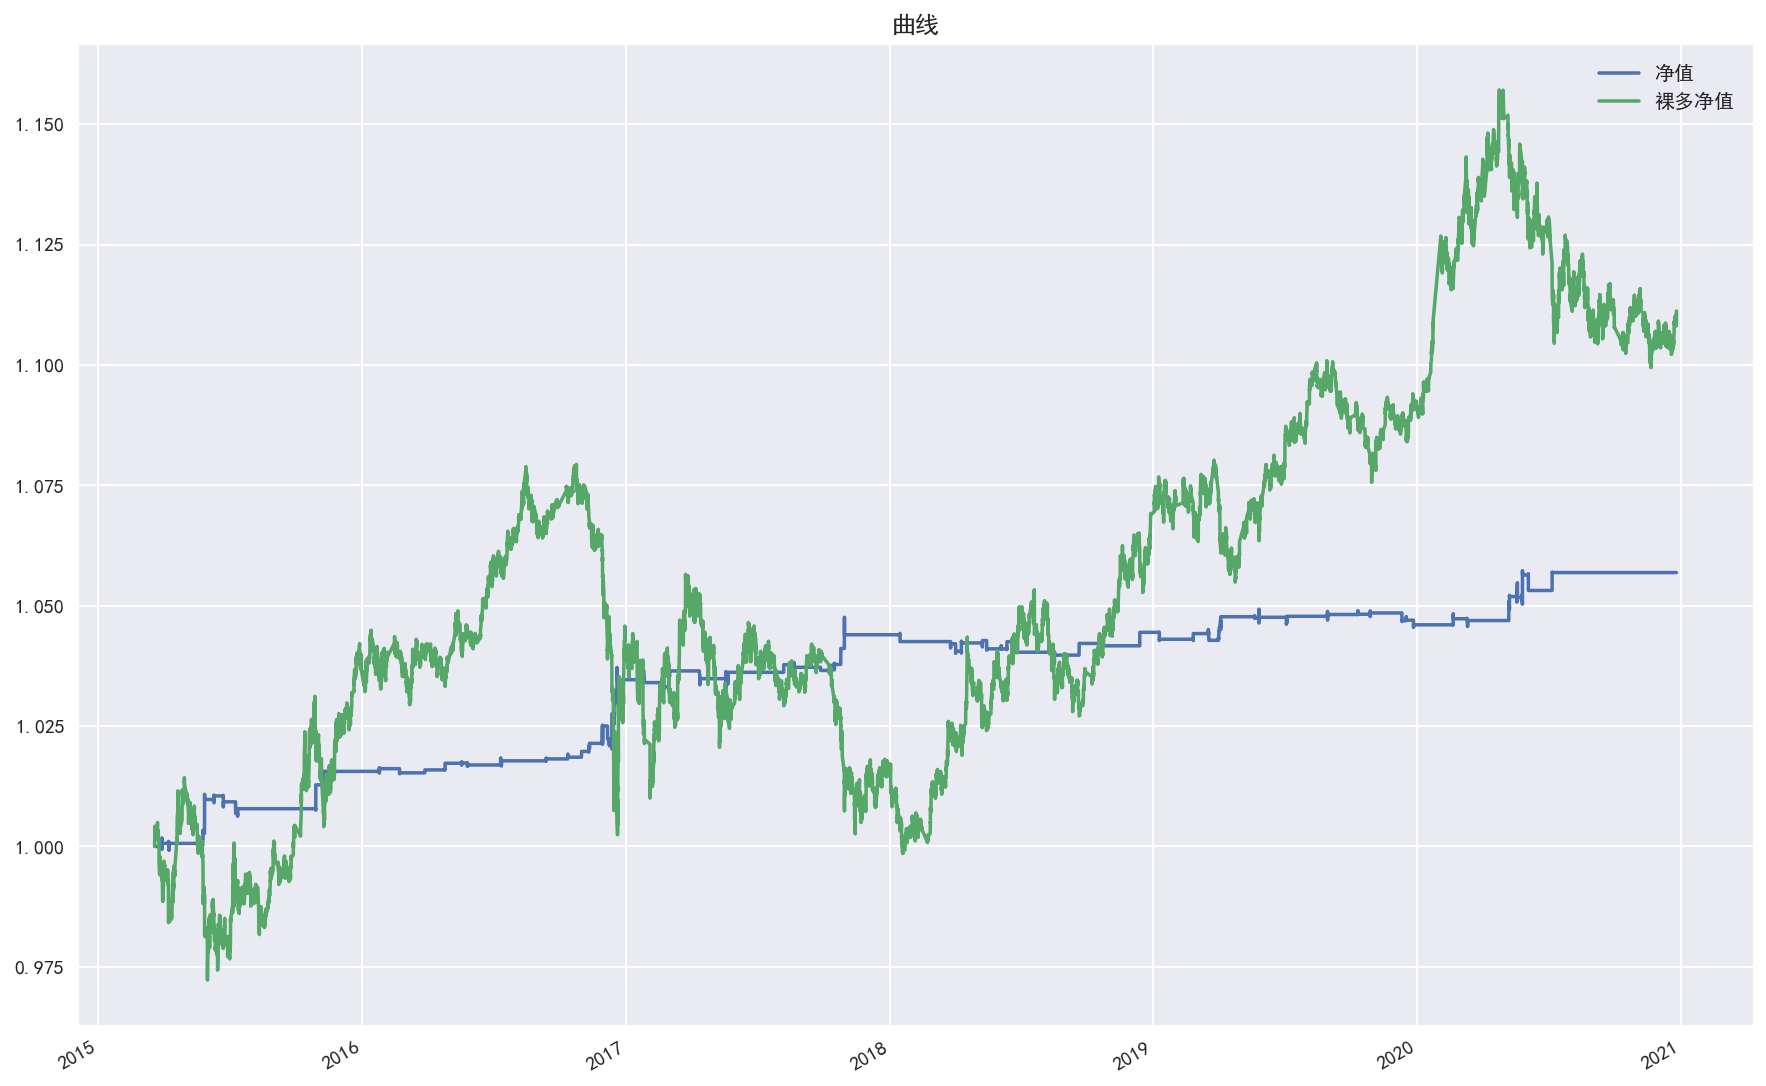

In [25]:
new = back_test(position_data, price_data/100,4*4.5)
new.show_result()
new.result_plot()

# TF

### 数据整合

In [34]:
###给出高/开/低/收
day_number = 18*3
year = [13,14,15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*9
file_name = ['TF'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]

def draw_data(raw_data):
    data = raw_data[['open','close','high','low','volume']]#我们只使用高开低收和成交量5个数据
    data.iloc[:,4] = data.iloc[:,4].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data['open'] = [0]*14+list(data.iloc[:-14,0].values)#开盘价
    data['high'] = data['high'].rolling(15).max()#最大值
    data['low'] = data['low'].rolling(15).min()#最小值
    
    data=data[data.index.minute.isin([15,30,45,0])] 
    data['open'] = data['open']/data['close']
    data['high'] = data['high']/data['close']
    data['low'] = data['low']/data['close']
    data['close'] = data['close'].pct_change()
    
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,4].rolling(day_number).sum()<nn.iloc[:,9].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()

future1.iloc[0,1] = 0
future_integrate = future1.loc[future1.index[1]:future1[(future1.iloc[:,4]>0).values].index[-1]]
TF_future_price = future_integrate.copy()
TF_future_price.iloc[:,1] = (TF_future_price.iloc[:,1]+1).cumprod()
TF_future_price['open'] = TF_future_price['open']*TF_future_price['close']
TF_future_price['high'] = TF_future_price['high']*TF_future_price['close']
TF_future_price['low'] = TF_future_price['low']*TF_future_price['close']
TF_future_price.iloc[:,0:4] = TF_future_price.iloc[:,0:4]*100

处理文件TF1303.CCFX.xlsx
处理文件TF1306.CCFX.xlsx
处理文件TF1309.CCFX.xlsx
处理文件TF1312.CCFX.xlsx
处理文件TF1403.CCFX.xlsx
合约切换时间： 2013-11-29 09:45:00
处理文件TF1406.CCFX.xlsx
合约切换时间： 2014-02-25 09:45:00
处理文件TF1409.CCFX.xlsx
合约切换时间： 2014-05-15 11:15:00
处理文件TF1412.CCFX.xlsx
合约切换时间： 2014-08-14 11:15:00
处理文件TF1503.CCFX.xlsx
合约切换时间： 2014-11-05 13:15:00
处理文件TF1506.CCFX.xlsx
合约切换时间： 2015-02-06 10:15:00
处理文件TF1509.CCFX.xlsx
合约切换时间： 2015-05-19 13:15:00
处理文件TF1512.CCFX.xlsx
合约切换时间： 2015-08-21 09:45:00
处理文件TF1603.CCFX.xlsx
合约切换时间： 2015-11-26 10:00:00
处理文件TF1606.CCFX.xlsx
合约切换时间： 2016-02-23 09:45:00
处理文件TF1609.CCFX.xlsx
合约切换时间： 2016-05-11 14:00:00
处理文件TF1612.CCFX.xlsx
合约切换时间： 2016-08-16 10:15:00
处理文件TF1703.CCFX.xlsx
合约切换时间： 2016-11-15 10:00:00
处理文件TF1706.CCFX.xlsx
合约切换时间： 2017-02-07 13:30:00
处理文件TF1709.CCFX.xlsx
合约切换时间： 2017-05-12 11:30:00
处理文件TF1712.CCFX.xlsx
合约切换时间： 2017-08-14 11:15:00
处理文件TF1803.CCFX.xlsx
合约切换时间： 2017-11-15 13:30:00
处理文件TF1806.CCFX.xlsx
合约切换时间： 2018-02-23 09:45:00
处理文件TF1809.CCFX.xlsx
合约切换时间： 2018-

In [36]:
gap = pd.DataFrame((TF_future_price.iloc[1:,0].values-TF_future_price.iloc[:-1,1].values),index =TF_future_price.index[1:])
box = []
for i in range(1,100):
    box.append(np.percentile(gap,i))
box

[-0.04621111403198781,
 -0.02098099301986167,
 -0.01271536652045924,
 -0.010365550220669206,
 -0.01015476485714828,
 -0.008215318561013873,
 -0.0053112323963802055,
 -0.005285061829525262,
 -0.005245248254965418,
 -0.005211710492744714,
 -0.00520630197294608,
 -0.005200326079901174,
 -0.005193280540893852,
 -0.005182775110313287,
 -0.0051779135242639995,
 -0.005176825621234116,
 -0.0051726595949048715,
 -0.005134568225770408,
 -0.005093091071344702,
 -0.005077205858015077,
 -0.005036211070418517,
 -0.004997463222537135,
 -0.004156525738949313,
 -0.0021192277533970127,
 -0.0020782628694462346,
 -2.842170943040401e-14,
 -2.842170943040401e-14,
 -2.842170943040401e-14,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 -1.4210854715202004e-14,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.42108547

In [274]:
future_price = TF_future_price
long_return = []
short_return = []
c=datetime.date(2021, 7, 6)
long =0
short = 0
for i in range(1,len(future_price)-36):
    if future_price.index[i]<c:
        morning = 8
        afternoon = 17
    if future_price.index[i]>=c:
        morning = 7
        afternoon = 16
        
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        if (future_price['low'][i:i+morning].min()>future_price['high'][i-1]):
            if future_price['open'].pct_change(6)[i+morning]>0:#上午最后15min开盘买入，下午收盘卖出
                long = (future_price['open'].pct_change(60)[i+morning]>0.00182)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+1]+future_price['close'][i+afternoon+1])/2
                long_return.append(sell_price/buy_price-1)
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
            if future_price['open'].pct_change(3)[i+morning]<0:
                short = (future_price['open'].pct_change(60)[i+morning]<-0.00127)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+short*morning+1]+future_price['close'][i+afternoon+short*morning+1])/2
                short_return.append(1-sell_price/buy_price)


long_return = np.array(long_return)
print("做多个数:",len(long_return))
print("做多胜率:",sum(np.array(long_return)>0)/len(long_return))
print("做多赔率:",-long_return[(np.array(long_return)>0)].mean()/long_return[(np.array(long_return)<0)].mean())

short_return = np.array(short_return)
print("做空个数:",len(short_return))
print("做空胜率:",sum(np.array(short_return)>0)/len(short_return))
print("做空赔率:",-short_return[(np.array(short_return)>0)].mean()/short_return[(np.array(short_return)<0)].mean())

做多个数: 103
做多胜率: 0.5145631067961165
做多赔率: 1.10962054297284
做空个数: 88
做空胜率: 0.5454545454545454
做空赔率: 1.4241361971596396


In [295]:
future_price = TF_future_price

#定义趋势项，当均线连续上涨则证明有趋势
price_ave1=future_price['close'].rolling(int(50)).mean()
up_trend = (price_ave1.pct_change()>0).rolling(50).sum()>48
down_trend = (price_ave1.pct_change()<0).rolling(50).sum()>48
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["trend"]
future_price['trend']=trend
future_price = future_price.dropna()

long_return = []
short_return = []
time = []
c=datetime.date(2021, 7, 6)
long =0
short = 0

for i in range(1,len(future_price)-36):
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        #判断是什么时候出现的缺口
        
        morning=8
        afternoon=16
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==30):
            morning = 8
            afternoon =9+8
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==40):
            morning = 7
            afternoon=9+7
            
        if (future_price['low'][i:i+morning].min()>=future_price['high'][i-1]):
            if (future_price['open'].pct_change(3)[i+morning]>0)*future_price['volume'][i]>1.5*future_price['volume'].rolling(30).mean().iloc[i]:#上午最后15min开盘买入，下午收盘卖出
            #if future_price['volume'][i]>3*future_price['volume'].rolling(30).mean().iloc[i]:
                long = (future_price['trend'][i+morning]>=0)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+long*morning+1]+future_price['close'][i+afternoon+1+long*morning])/2
                long_return.append(sell_price/buy_price-1)
                time.append(future_price.index[i])
                
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        morning=8
        afternoon=16
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==30):
            morning = 8
            afternoon =9+8
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==40):
            morning = 7
            afternoon=9+7    
    
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
    
            if (future_price['open'].pct_change(3)[i+morning]<0)*(future_price['volume'][i]>1.5*future_price['volume'].rolling(30).mean().iloc[i]):
                long = (future_price['trend'][i+morning]<=0)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+short*morning+1]+future_price['close'][i+afternoon+short*morning+1])/2
                short_return.append(1-sell_price/buy_price)
                time.append(future_price.index[i])

long_return = np.array(long_return)
long_win = sum(np.array(long_return)>0)/len(long_return)
long_odd = -long_return[(np.array(long_return)>0)].mean()/long_return[(np.array(long_return)<0)].mean()
print("做多个数:",len(long_return))
print("做多胜率:",long_win)
print("做多赔率:",long_odd)
print("做多预期收益倍数;",(1+long_odd)*long_win-1)


short_return = np.array(short_return)
short_win = sum(np.array(short_return)>0)/len(short_return)
short_odd = -short_return[(np.array(short_return)>0)].mean()/short_return[(np.array(short_return)<0)].mean()
print("做空个数:",len(short_return))
print("做空胜率:",short_win)
print("做空赔率:",short_odd)
print("做空预期收益倍数;",(1+short_odd)*short_win-1)

做多个数: 87
做多胜率: 0.5402298850574713
做多赔率: 1.0081656287001735
做多预期收益倍数; 0.08487108676905941
做空个数: 72
做空胜率: 0.6527777777777778
做空赔率: 1.1868737159861371
做空预期收益倍数; 0.42754256460206186


# TS

### 数据整合

In [59]:
###给出高/开/低/收
day_number = 18*3
year = [13,14,15,16,17,18,19,20,21]*4
year = sorted(year)
month = ['03','06','09','12']*9
file_name = ['TS'+str(x)+y + '.CCFX.xlsx' for x,y in zip(year,month)]

def draw_data(raw_data):
    data = raw_data[['open','close','high','low','volume']]#我们只使用高开低收和成交量5个数据
    data.iloc[:,4] = data.iloc[:,4].rolling(15).sum()#价格用该时间点的价格即可，成交量要算求和,这里假设用的是15min来进行slice
    data['open'] = [0]*14+list(data.iloc[:-14,0].values)#开盘价
    data['high'] = data['high'].rolling(15).max()#最大值
    data['low'] = data['low'].rolling(15).min()#最小值
    
    data=data[data.index.minute.isin([15,30,45,0])] 
    data['open'] = data['open']/data['close']
    data['high'] = data['high']/data['close']
    data['low'] = data['low']/data['close']
    data['close'] = data['close'].pct_change()
    
    return data

def get_return_flow(future1,future2):
    #输入两个期货价格的dataframe，需注意future1是已有的序列，future2是要加入的序列
    nn = pd.concat([future1,future2],axis=1)
    #当过去1天的下一期期货成交量超过上一期的，定义为主力合约的切换
    index = nn[(nn.iloc[:,4].rolling(day_number).sum()<nn.iloc[:,9].rolling(day_number).sum()).values].index[1]
    print("合约切换时间：",index)
    result = pd.concat([future1.loc[:index].iloc[:-1],future2.loc[index:]],axis=0)
    return result

initial =1
for name in file_name:
    print("处理文件"+name)
    #print('内存使用占比：',psutil.Process(os.getpid()).memory_info().rss/info.total)
    try:
        file_location = './data_minute/'+name
        raw_data = pd.read_excel(file_location,index_col=0 )
    except:
        continue
        
    if initial==1:
        initial =0
        future1 = draw_data(raw_data)
        del raw_data
        gc.collect()
        continue
        
    future2 = draw_data(raw_data)
    try:
        future1 = get_return_flow(future1,future2)
    except:
        print("数据整合结束")
        break
    del future2, raw_data
    gc.collect()

future1.iloc[0,1] = 0
future_integrate = future1.loc[future1.index[1]:future1[(future1.iloc[:,4]>0).values].index[-1]]
TS_future_price = future_integrate.copy()
TS_future_price.iloc[:,1] = (TS_future_price.iloc[:,1]+1).cumprod()
TS_future_price['open'] = TS_future_price['open']*TS_future_price['close']
TS_future_price['high'] = TS_future_price['high']*TS_future_price['close']
TS_future_price['low'] = TS_future_price['low']*TS_future_price['close']
TS_future_price.iloc[:,0:4] = TS_future_price.iloc[:,0:4]*100

处理文件TS1303.CCFX.xlsx
处理文件TS1306.CCFX.xlsx
处理文件TS1309.CCFX.xlsx
处理文件TS1312.CCFX.xlsx
处理文件TS1403.CCFX.xlsx
处理文件TS1406.CCFX.xlsx
处理文件TS1409.CCFX.xlsx
处理文件TS1412.CCFX.xlsx
处理文件TS1503.CCFX.xlsx
处理文件TS1506.CCFX.xlsx
处理文件TS1509.CCFX.xlsx
处理文件TS1512.CCFX.xlsx
处理文件TS1603.CCFX.xlsx
处理文件TS1606.CCFX.xlsx
处理文件TS1609.CCFX.xlsx
处理文件TS1612.CCFX.xlsx
处理文件TS1703.CCFX.xlsx
处理文件TS1706.CCFX.xlsx
处理文件TS1709.CCFX.xlsx
处理文件TS1712.CCFX.xlsx
处理文件TS1803.CCFX.xlsx
处理文件TS1806.CCFX.xlsx
处理文件TS1809.CCFX.xlsx
处理文件TS1812.CCFX.xlsx
处理文件TS1903.CCFX.xlsx
合约切换时间： 2018-11-20 14:45:00
处理文件TS1906.CCFX.xlsx
合约切换时间： 2019-02-22 15:00:00
处理文件TS1909.CCFX.xlsx
合约切换时间： 2019-05-16 09:45:00
处理文件TS1912.CCFX.xlsx
合约切换时间： 2019-05-21 14:45:00
处理文件TS2003.CCFX.xlsx
合约切换时间： 2019-11-13 10:45:00
处理文件TS2006.CCFX.xlsx
合约切换时间： 2020-02-21 10:00:00
处理文件TS2009.CCFX.xlsx
合约切换时间： 2020-05-15 15:15:00
处理文件TS2012.CCFX.xlsx
合约切换时间： 2020-08-24 10:45:00
处理文件TS2103.CCFX.xlsx
合约切换时间： 2020-11-25 13:15:00
处理文件TS2106.CCFX.xlsx
数据整合结束


In [60]:
gap = pd.DataFrame((TS_future_price.iloc[1:,0].values-TS_future_price.iloc[:-1,1].values),index = TS_future_price.index[1:])
box = []
for i in range(1,100):
    box.append(np.percentile(gap,i))

In [62]:
future_price = TS_future_price
long_return = []
short_return = []
c=datetime.date(2020, 7, 6)
long =0
short = 0
for i in range(1,len(future_price)-36):
    if future_price.index[i]<c:
        morning = 8
        afternoon = 17
    if future_price.index[i]>=c:
        morning = 7
        afternoon = 16
        
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        if (future_price['low'][i:i+morning].min()>future_price['high'][i-1]):
            if future_price['open'].pct_change(6)[i+morning]>0:#上午最后15min开盘买入，下午收盘卖出
                long = (future_price['open'].pct_change(60)[i+morning]>0.00182)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+long*morning+1]+future_price['close'][i+afternoon+1+long*morning])/2
                long_return.append(sell_price/buy_price-1)
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
            if future_price['open'].pct_change(3)[i+morning]<0:
                short = (future_price['open'].pct_change(60)[i+morning]<-0.00127)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+short*morning+1]+future_price['close'][i+afternoon+short*morning+1])/2
                short_return.append(1-sell_price/buy_price)


long_return = np.array(long_return)
print("做多个数:",len(long_return))
print("做多胜率:",sum(np.array(long_return)>0)/len(long_return))
print("做多赔率:",-long_return[(np.array(long_return)>0)].mean()/long_return[(np.array(long_return)<0)].mean())

short_return = np.array(short_return)
print("做空个数:",len(short_return))
print("做空胜率:",sum(np.array(short_return)>0)/len(short_return))
print("做空赔率:",-short_return[(np.array(short_return)>0)].mean()/short_return[(np.array(short_return)<0)].mean())

做多个数: 49
做多胜率: 0.5714285714285714
做多赔率: 1.4712121043215762
做空个数: 17
做空胜率: 0.6470588235294118
做空赔率: 1.844109881442166


In [296]:
future_price = TS_future_price

#定义趋势项，当均线连续上涨则证明有趋势
price_ave1=future_price['close'].rolling(int(50)).mean()
up_trend = (price_ave1.pct_change()>0).rolling(50).sum()>48
down_trend = (price_ave1.pct_change()<0).rolling(50).sum()>48
trend = pd.DataFrame(pd.concat([up_trend*1,down_trend*(-1)],axis=1).sum(axis=1))
trend.columns = ["trend"]
future_price['trend']=trend
future_price = future_price.dropna()

long_return = []
short_return = []
time = []
c=datetime.date(2021, 7, 6)
long =0
short = 0

for i in range(1,len(future_price)-36):
    if ((future_price['open'][i] - future_price['close'][i-1])>0.005) and (future_price['open'][i]<future_price['close'][i]) :
        #判断是什么时候出现的缺口
        
        morning=8
        afternoon=16
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==30):
            morning = 8
            afternoon =9+8
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==40):
            morning = 7
            afternoon=9+7
            
        if (future_price['low'][i:i+morning].min()>=future_price['high'][i-1]):
            if (future_price['open'].pct_change(3)[i+morning]>0)*future_price['volume'][i]>1.5*future_price['volume'].rolling(30).mean().iloc[i]:#上午最后15min开盘买入，下午收盘卖出
            #if future_price['volume'][i]>3*future_price['volume'].rolling(30).mean().iloc[i]:
                long = (future_price['trend'][i+morning]>=0)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+long*morning+1]+future_price['close'][i+afternoon+1+long*morning])/2
                long_return.append(sell_price/buy_price-1)
                time.append(future_price.index[i])
                
                
    if ((future_price['open'][i] - future_price['close'][i-1])<-0.005) and (future_price['open'][i]>future_price['close'][i]) :
        morning=8
        afternoon=16
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==30):
            morning = 8
            afternoon =9+8
        if (future_price.index[i].hour==9)and(future_price.index[i].minute==40):
            morning = 7
            afternoon=9+7    
    
        if (future_price['high'][i:i+morning].max()<future_price['low'][i-1]) :
    
            if (future_price['open'].pct_change(3)[i+morning]<0)*(future_price['volume'][i]>1.5*future_price['volume'].rolling(30).mean().iloc[i]):
                long = (future_price['trend'][i+morning]<=0)*1
                buy_price = (future_price['open'][i+morning]+future_price['close'][i+morning])/2
                sell_price = (future_price['open'][i+afternoon+short*morning+1]+future_price['close'][i+afternoon+short*morning+1])/2
                short_return.append(1-sell_price/buy_price)
                time.append(future_price.index[i])

long_return = np.array(long_return)
long_win = sum(np.array(long_return)>0)/len(long_return)
long_odd = -long_return[(np.array(long_return)>0)].mean()/long_return[(np.array(long_return)<0)].mean()
print("做多个数:",len(long_return))
print("做多胜率:",long_win)
print("做多赔率:",long_odd)
print("做多预期收益倍数;",(1+long_odd)*long_win-1)


short_return = np.array(short_return)
short_win = sum(np.array(short_return)>0)/len(short_return)
short_odd = -short_return[(np.array(short_return)>0)].mean()/short_return[(np.array(short_return)<0)].mean()
print("做空个数:",len(short_return))
print("做空胜率:",short_win)
print("做空赔率:",short_odd)
print("做空预期收益倍数;",(1+short_odd)*short_win-1)

做多个数: 23
做多胜率: 0.6086956521739131
做多赔率: 1.363898246798509
做多预期收益倍数; 0.4388945850077881
做空个数: 10
做空胜率: 0.5
做空赔率: 3.0923335360416826
做空预期收益倍数; 1.046166768020841
